In [ ]:
!nvidia-smi

Sat Dec  9 04:57:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7d3e04b20b1da4df28fddf597e490eb3aac6b9f9576b508a267ac99066ec733f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=93937317b446ebafa57933232b68356bd7af8f542c267401b4ecfe8e812cc118
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation


In [ ]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask): # mask là 1 image RGB (H, W, 3)
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32) # tạo 1 object mask (H, W, 21)
        for label_index, label in enumerate(VOC_COLORMAP):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float) # mask == label trả về matrix T/F (H, W, 3) check từng pixel theo chiều sâu channels.
                                                                                              # np.all sẽ kiểm tra nếu pixel nào có channel cùng màu với VOC_COLORMAP thì trả về True, ta dc 1 matrix True/False (H, W).
                                                                                              # astype() convert matrix [True False] về kiểu float [1. 0.]

        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor argmax()-> (H, W, 1) -> (H, W) #numpy

In [ ]:
trainsize = 257

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

100%|██████████| 1999639040/1999639040 [01:13<00:00, 27162132.25it/s]


Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


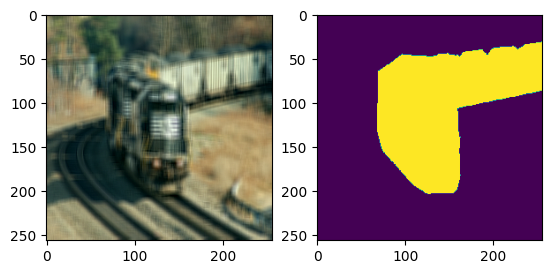

In [ ]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()


In [ ]:
x = np.arange(24).reshape((2, 3, 4)) # 2 samples, mỗi sample có 3 gàn 4 cột
print(x)
res = np.argmax(x, axis=1, keepdims = True) # keepdims giữ shape output = shape input
print(res)
print(res.shape)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]]
[[[2 2 2 2]]

 [[2 2 2 2]]]
(2, 1, 4)


In [ ]:
#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_down1 = unet_block(3, 64)
        self.block_down2 = unet_block(64, 128)
        self.block_down3 = unet_block(128, 256)
        self.block_down4 = unet_block(256, 512)
        self.block_neck = unet_block(512, 1024)
        self.block_up1 = unet_block(1024+512, 512)
        self.block_up2 = unet_block(256+512, 256)
        self.block_up3 = unet_block(128+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

    def forward(self, x):
        # (B, C, H, W)
        print(x.shape)
        x1 = self.block_down1(x)
        x = self.downsample(x1)
        x2 = self.block_down2(x)
        x = self.downsample(x2)
        x3 = self.block_down3(x)
        x = self.downsample(x3)
        x4 = self.block_down4(x)
        x = self.downsample(x4)

        x = self.block_neck(x)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x)
        return x

model1 = UNet(21)
x = torch.rand(2, 3, 256, 256)
y = model1(x)
print(y.shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 21, 256, 256])


In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = UNet(21).to(device)

#loss
criterion = nn.CrossEntropyLoss() # CrossEntropy loss cho multiple classes

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 20

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


In [ ]:
for ep in range(1, 1+n_eps):
  acc_meter.reset()
  train_loss_meter.reset()
  dice_meter.reset()
  iou_meter.reset()
  model.train()

  for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long() # hàm entropy loss nhận output là indices của class trong class_list nên chuyển sang long = int64
    y_hat = model(x) #(B, C, H, W)
    loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      accuracy = accuracy_function(y_hat_mask, y.long())

      train_loss_meter.update(loss.item(), n)
      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(accuracy.item(), n)

  print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
  ))
  if ep >= 15:
      torch.save(model.state_dict(), "/content/modelUNet_ep_{}.pth".format(ep))

In [ ]:
!pip install timm

In [ ]:
import timm
backbone = timm.create_model("resnet101", features_only=True, pretrained=True)
x = torch.rand(2, 3, 256,256)
features = backbone(x)
for feature in features:
  print(feature.shape)

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

torch.Size([2, 64, 128, 128])
torch.Size([2, 256, 64, 64])
torch.Size([2, 512, 32, 32])
torch.Size([2, 1024, 16, 16])
torch.Size([2, 2048, 8, 8])


In [ ]:
class ResUnet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.backbone = timm.create_model("resnet101", features_only=True, pretrained=True)
    self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
    self.block_neck = unet_block(2048, 1024)
    self.block_up1 = unet_block(1024+1024, 512)
    self.block_up2 = unet_block(512+512, 256)
    self.block_up3 = unet_block(256+256, 128)
    self.block_up4 = unet_block(128+64, 64)
    self.conv_cls = nn.Conv2d(64, self.n_classes, 1) # -> (B, n_class, H, W)

  def forward(self, x):
    x1, x2, x3, x4, x5 = self.backbone(x)

    x = self.block_neck(x5)
    x = torch.cat([x4, self.upsample(x)], dim=1)
    x = self.block_up1(x)
    x = torch.cat([x3, self.upsample(x)], dim=1)
    x = self.block_up2(x)
    x = torch.cat([x2, self.upsample(x)], dim=1)
    x = self.block_up3(x)
    x = torch.cat([x1, self.upsample(x)], dim=1)
    x = self.block_up4(x)
    x = self.conv_cls(x) # B, n_class, H/2, W/2

    x = self.upsample(x) # B, 21, H, W


    return x

# model2 = ResUnet(21)
# x = torch.rand(2, 3, 256, 256)
# y = model2(x)
# print(y.shape)

In [ ]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 8
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model2 = ResUnet(21).to(device)

#loss
criterion = nn.CrossEntropyLoss() # CrossEntropy loss cho multiple classes

#optimizer
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
n_eps = 20

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

num_workers = 2


In [ ]:
for ep in range(1, 1+n_eps):
  acc_meter.reset()
  train_loss_meter.reset()
  dice_meter.reset()
  iou_meter.reset()
  model2.train()

  for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long() # hàm entropy loss nhận output là indices của class trong class_list nên chuyển sang long = int64
    y_hat = model2(x) #(B, C, H, W)
    loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      accuracy = accuracy_function(y_hat_mask, y.long())

      train_loss_meter.update(loss.item(), n)
      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(accuracy.item(), n)

  print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
  ))
  if ep >= 15:
      torch.save(model2.state_dict(), "/content/modelResUnet_ep_{}.pth".format(ep))

100%|██████████| 183/183 [04:21<00:00,  1.43s/it]


EP 1, train loss = 1.2080540992523152, accuracy = 0.738421549562548, IoU = 0.07844592777466002, dice = 0.08946415564350292


100%|██████████| 183/183 [04:04<00:00,  1.34s/it]


EP 2, train loss = 1.0043342072781318, accuracy = 0.7519721567956477, IoU = 0.08937696227040447, dice = 0.1038405145289468


100%|██████████| 183/183 [03:58<00:00,  1.30s/it]


EP 3, train loss = 0.9279023174379692, accuracy = 0.769051994782328, IoU = 0.11193706213287968, dice = 0.13360012444804925


100%|██████████| 183/183 [03:59<00:00,  1.31s/it]


EP 4, train loss = 0.8100508873254224, accuracy = 0.793087985346226, IoU = 0.14357559684195806, dice = 0.17351430186319872


100%|██████████| 183/183 [03:56<00:00,  1.29s/it]


EP 5, train loss = 0.7077250309654923, accuracy = 0.8102227924951438, IoU = 0.16481765866523884, dice = 0.19714309051225745


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 6, train loss = 0.6323130226037541, accuracy = 0.8237257160124232, IoU = 0.18547149171513286, dice = 0.2228085476029766


100%|██████████| 183/183 [03:56<00:00,  1.29s/it]


EP 7, train loss = 0.573526656855651, accuracy = 0.8363700825008539, IoU = 0.21391143763814469, dice = 0.25658240197786214


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 8, train loss = 0.5081292910328328, accuracy = 0.8508960744722294, IoU = 0.23461183111687176, dice = 0.28026149539999623


100%|██████████| 183/183 [03:54<00:00,  1.28s/it]


EP 9, train loss = 0.4651860583349655, accuracy = 0.8641560038582223, IoU = 0.2776931383000697, dice = 0.3290290699793341


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 10, train loss = 0.4288109870719128, accuracy = 0.8730391726467779, IoU = 0.2976745769300096, dice = 0.3515362366626823


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 11, train loss = 0.39122734532330206, accuracy = 0.8830389950444789, IoU = 0.3308503999898994, dice = 0.3874712627930719


100%|██████████| 183/183 [03:56<00:00,  1.29s/it]


EP 12, train loss = 0.35056632231982027, accuracy = 0.8947352529223499, IoU = 0.36419882409559573, dice = 0.4208880221583153


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 13, train loss = 0.3244807861053227, accuracy = 0.9016484640986542, IoU = 0.3770811328145324, dice = 0.43602928380822875


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 14, train loss = 0.3142409609640882, accuracy = 0.9045613606770834, IoU = 0.3908691570732763, dice = 0.44938632153748165


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 15, train loss = 0.28548611525466533, accuracy = 0.9120430972406773, IoU = 0.4204407915717266, dice = 0.4808576095625351


100%|██████████| 183/183 [03:55<00:00,  1.29s/it]


EP 16, train loss = 0.26359220162604025, accuracy = 0.9173851221636996, IoU = 0.43941804742226837, dice = 0.49933863679567975


100%|██████████| 183/183 [03:54<00:00,  1.28s/it]


EP 17, train loss = 0.2504200725281825, accuracy = 0.9212910594835959, IoU = 0.4655340903443717, dice = 0.5252914096488327


100%|██████████| 183/183 [03:53<00:00,  1.28s/it]


EP 18, train loss = 0.23923496527424276, accuracy = 0.9241357501087293, IoU = 0.477561854925312, dice = 0.5400302416639902


100%|██████████| 183/183 [03:55<00:00,  1.28s/it]


EP 19, train loss = 0.2267993900293861, accuracy = 0.9268295621611381, IoU = 0.4879094643996713, dice = 0.5498772390553208


100%|██████████| 183/183 [03:52<00:00,  1.27s/it]


EP 20, train loss = 0.225873891650979, accuracy = 0.9278122636138416, IoU = 0.4893841195464786, dice = 0.5511369700314569


In [ ]:
# model -> UNet
# model2 -> ResUnet
def test_pascalvoc(model):
  acc_meter = AverageMeter()
  dice_meter = AverageMeter()
  iou_meter = AverageMeter()
  model.eval()
  with torch.no_grad():
    for batch_id, (x,y) in enumerate(tqdm(testloader), start=1):
      n = x.shape[0]
      x = x.to(device).float()
      y = y.to(device).long()
      y_hat = model(x)
      y_hat_mask = y_hat.argmax(dim=1).squeeze() # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      accuracy = accuracy_function(y_hat_mask, y.long())

      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(accuracy.item(), n)
  print("TEST: acc = {}, iou = {}, dice = {}".format(acc_meter.avg, iou_meter.avg, dice_meter.avg))


In [ ]:
test_pascalvoc(model)
test_pascalvoc(model2)

In [ ]:
#predict visulization
import random
id = random.randint(0, test_dataset.__len__())
with torch.no_grad():
    model.eval()
    x, y = test_dataset.__getitem__(id)
    y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
    for i in np.unique(y_predict).tolist():
        print(VOC_CLASSES[i])
    color_mask_predict = np.zeros((y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask_predict[y_predict==i] = np.array(color)
    color_mask = np.zeros((*y_predict.shape, 3))
    for i, color in enumerate(VOC_COLORMAP):
        color_mask[y==i] = np.array(color)
    plt.subplot(1,3,1)
    plt.imshow(unorm(x).permute(1, 2, 0))
    plt.subplot(1,3,2)
    plt.imshow(color_mask)
    plt.subplot(1,3,3)
    plt.imshow(color_mask_predict)
    plt.show()